In [1]:
import numpy as np
import jax
from jax import jit, vmap
from jax.flatten_util import ravel_pytree
import jax.numpy as jnp

import blackjax
from blackjax.vi.svgd import SVGDState

import optax

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
def gaussian_mixture(x, mu1=-2, mu2=2):
    pdf = lambda x, mu: jax.scipy.stats.norm.pdf(x, loc=mu, scale=1)
    return (1/3)*pdf(x, mu1) + (2/3)*pdf(x, mu2)

def gaussian_mixture_log_pdf(x):
    return jnp.log(gaussian_mixture(x))

In [3]:

@jit
def rbf_kernel(x, y, length_scale=1):
    arg = jnp.atleast_1d(x - y)**2
    return jnp.exp(-(1/length_scale) * arg.sum())

@jit
def median_heuristic(kernel_parameters, particles):
    particle_array = vmap(lambda p: ravel_pytree(p)[0])(particles)

    def distance(x,y):
        return jnp.linalg.norm(jnp.atleast_1d(x-y))

    vmapped_distance = vmap(vmap(distance, (None,0)), (0,None))
    A = vmapped_distance(particle_array, particle_array) # Calculate distance matrix
    pairwise_distances = A[jnp.tril_indices(A.shape[0], k=-1)] # Take values below the main diagonal into a vector
    median = jnp.median(pairwise_distances)
    kernel_parameters["length_scale"] = (median**2) / jnp.log(particle_array.shape[0])
    return kernel_parameters


def update_kernel_parameters(state: SVGDState) -> SVGDState:
    position, kernel_parameters, opt_state = state
    return SVGDState(position, median_heuristic(kernel_parameters, position), opt_state)

def svgd_training_loop(
        initial_position,
        initial_kernel_parameters,
        log_p,
        kernel,
        optimizer,
        *,
        num_iterations=500,
        progress=False
        ):
    svgd = blackjax.svgd(log_p, optimizer, kernel)
    state = svgd.init(initial_position, initial_kernel_parameters)
    step = jax.jit(svgd.step)
    for _ in range(num_iterations):
        state = step(state)
        state = update_kernel_parameters(state)
        print(_)
        print(state)
    return state

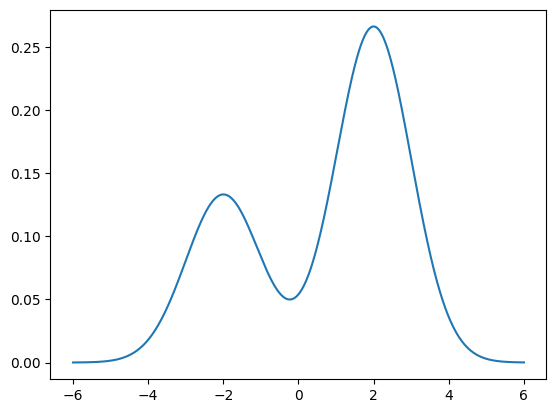

In [4]:
fig = plt.figure()
ax = fig.subplots()
x = jnp.linspace(-6, 6, 10000)
sns.lineplot(y=vmap(gaussian_mixture)(x), x=x, ax=ax);

In [5]:
num_particles = 100

# Sample initial particles from a (-10, 1) normal distribution
initial_particles = (-10) + jax.random.normal(
        jax.random.PRNGKey(3), 
        shape=(num_particles,)
        )

<Axes: ylabel='Density'>

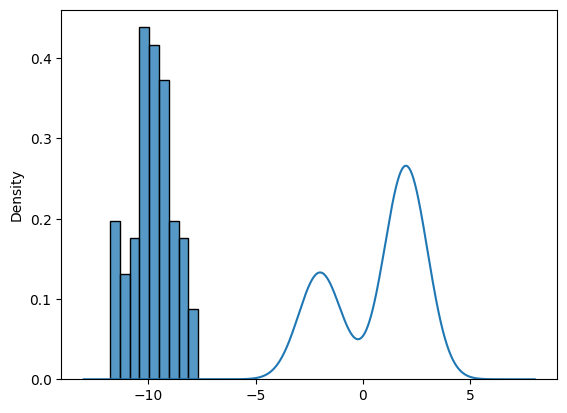

In [6]:
fig = plt.figure()
ax = fig.subplots()
x = jnp.linspace(-13, 8, 10000)
sns.histplot(initial_particles, ax=ax, stat="density")
sns.lineplot(y=vmap(gaussian_mixture)(x), x=x, ax=ax)

In [7]:
# Run the algorithm
out = svgd_training_loop(
    initial_particles, 
    initial_kernel_parameters=median_heuristic({"length_scale": 1}, initial_particles),
    log_p = gaussian_mixture_log_pdf,
    kernel=rbf_kernel,
    optimizer=optax.adam(0.3),
    num_iterations=1000,
    progress=True
    )

0
SVGDState(particles=Array([ -9.544103 ,  -9.853137 ,  -9.328959 ,  -9.757974 ,  -9.447068 ,
        -9.697927 , -12.046233 ,  -9.527519 , -11.544023 ,  -8.45758  ,
        -9.65241  , -11.81834  , -10.105647 ,  -8.847633 , -11.38225  ,
        -9.129577 ,  -9.812977 , -11.554698 , -11.736497 ,  -9.711152 ,
        -9.741638 , -11.289639 ,  -9.916385 , -10.661567 , -10.583245 ,
        -8.887803 ,  -8.394606 , -10.399747 , -10.918283 ,  -9.736753 ,
       -10.930283 , -10.0351   , -10.536173 , -10.627335 ,  -9.965537 ,
        -9.32983  , -10.298093 , -10.395484 , -10.890021 , -10.368423 ,
        -8.300304 , -11.763699 ,  -8.167145 ,  -9.481286 , -10.685043 ,
       -10.325769 ,  -9.289995 , -11.6860285, -10.594486 , -10.584614 ,
       -11.868601 , -12.077276 , -10.341908 ,  -8.691583 ,  -9.26343  ,
       -10.661843 , -10.860019 ,  -9.390011 ,  -8.961983 ,  -9.891165 ,
       -10.402939 , -10.463569 , -10.363352 , -11.708775 ,  -9.968941 ,
        -9.664455 , -11.259501 , -10.20246

c:\Users\12lui\anaconda3\envs\NewTrading\lib\site-packages\numpy\lib\histograms.py:883: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


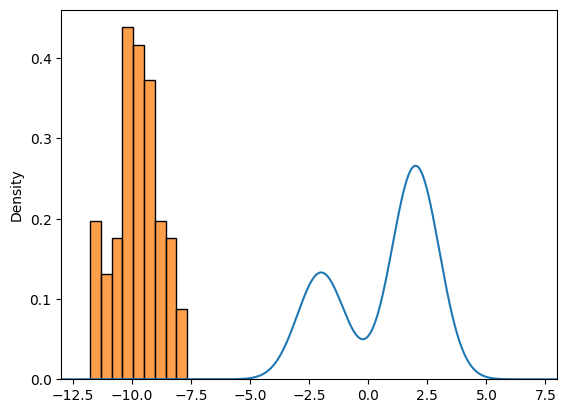

In [8]:
# Plot the results
def plot(particles):
    fig = plt.figure()
    ax = fig.subplots()
    x = jnp.linspace(-13, 8, 10000)
    sns.histplot(particles, ax=ax, stat="density")
    sns.histplot(initial_particles, ax=ax, stat="density")
    sns.lineplot(y=vmap(gaussian_mixture)(x), x=x, ax=ax)
    plt.xlim([-13, 8]);
    # plt.show()
plot(out.particles)

In [9]:
print(f"Estimated expectation: {out.particles.mean()}")
print(f"True expectation: {2/3}")

Estimated expectation: nan
True expectation: 0.6666666666666666
